In [1]:
import igraph as ig
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import powerlaw

from tqdm import trange, tqdm

from collections import defaultdict
from itertools import combinations

In [14]:
# # Read DBLP
edges = pd.read_csv("../../SNAP/com-lj.ungraph.txt", sep='\t', comment="#")
coms = []
with open("../../SNAP/com-lj.all.cmty.txt", "r") as infile:
    for line in infile:
        x = line[:-1]  # drop trailing newline
        x = x.split('\t')
        coms.append(frozenset([int(y) for y in x])) ## map to 0-based

g = ig.Graph.DataFrame(edges, directed=False)

c = [set() for _ in range(g.vcount())]
for i, com in enumerate(coms):
    for v in com:
        c[v].add(i)
        #print(f"Vertex {v} in community {i}")
        #print(f"Vetrex {v} is now in {len(c[v])} coms")
c = [frozenset(i) for i in c] 
g.vs["comms"] = c

g = g.subgraph(np.arange(g.vcount())[np.array(g.degree()) > 0])  # Vertex list is not continugous, degree 0 vertices get added


print(f"{g.vcount()} vertices")
print(f"{g.ecount()} edges")
print(f"{len(coms)} communities")

# Dropping some vars to free up memory
del edges


3997962 vertices
34681188 edges
664414 communities


Min size: 2
Max size: 178899
Mean: 10.788994512457593
Community Size powerlaw exponent:  2.23         


Text(0, 0.5, 'Frequency')

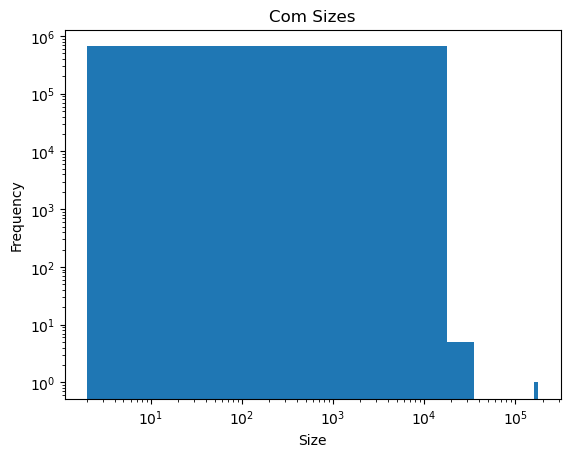

In [15]:
com_sizes = np.array([len(com) for com in coms])

print(f"Min size: {np.min(com_sizes)}")
print(f"Max size: {np.max(com_sizes)}")
print(f"Mean: {np.mean(com_sizes)}")
print(f"Community Size powerlaw exponent: {powerlaw.Fit(com_sizes, discrete=True, verbose=False, xmin=np.min(com_sizes)).power_law.alpha: .2f}         ")

plt.hist(com_sizes, log=True)
plt.xscale("log")
plt.title("Com Sizes")
plt.xlabel("Size")
plt.ylabel("Frequency")

Mean: 1.793003285173796
Mean for non-zero: 6.2444980086205994
Min for non-zero: 1
Max: 682
# no coms: 2850014
% no coms: 0.7128667055864963
Communities per nodes powerlaw exponent:  4.64         


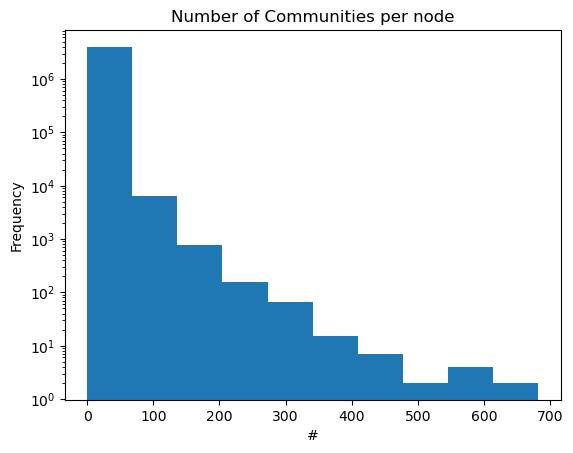

In [16]:
lens = np.array([len(i) for i in g.vs["comms"]])
plt.hist(lens, log=True)
plt.title("Number of Communities per node")
plt.xlabel("#")
plt.ylabel("Frequency")

print(f"Mean: {np.mean(lens)}")
print(f"Mean for non-zero: {np.mean(lens[lens>0])}")
print(f"Min for non-zero: {np.min(lens[lens>0])}")
print(f"Max: {np.max(lens)}")
print(f"# no coms: {np.sum(lens == 0)}")
print(f"% no coms: {np.sum(lens == 0) / len(lens)}")
print(f"Communities per nodes powerlaw exponent: {powerlaw.Fit(lens[lens>0], discrete=True, verbose=False).power_law.alpha: .2f}         ")

In [17]:
print("Graph measurements for generating similar ABCDoo graphs.")

print(f"n = {g.vcount()}")
print(f"nout = {np.sum(lens == 0)}")
eta = np.mean(lens[lens>0])
print(f"eta = {eta: .2f}")

degrees = np.array(g.degree())
d_min = np.maximum(5, np.min(degrees))
print(f"d_min = {d_min}")
print(f"d_max = {np.max(degrees)}")
print(f"t1 = {powerlaw.Fit(degrees, discrete=True, verbose=False, xmin=d_min).power_law.alpha: .2f}         ") # Spaces are required to prevent some buffer overflow from printing a progress notice

com_sizes = np.array([len(com) for com in coms])
c_min = np.maximum(10, np.min(com_sizes))
print(f"c_min = {c_min}")
print(f"c_max = {np.max(com_sizes)}")
print(f"t2 = {powerlaw.Fit(com_sizes, discrete=True, verbose=False, xmin=10).power_law.alpha: .2f}         ") # Spaces are required to prevent some buffer overflow from printing a progress notice

xi = sum([len(g.vs[e.source]["comms"].intersection(g.vs[e.target]["comms"]))==0 for e in g.es]) / g.ecount()
print(f"xi = {xi: .2f}")

rho = np.corrcoef(degrees, [len(c) for c in g.vs["comms"]])[0, 1]
print(f"rho = {rho: .2f}")

print(f"\n\nSince we measure t2 using communities larger than 10, we set c_min=10 in our experiments.")
print(f"Since d_min is typically 0 or 1 and casuses issues in generation, we set (and fit the powerlaw) to d_min =5")

Graph measurements for generating similar ABCDoo graphs.
n = 3997962
nout = 2850014
eta =  6.24
d_min = 5
d_max = 14815
t1 =  1.74         
c_min = 10
c_max = 178899
t2 =  1.88         
xi =  0.71
rho =  0.43


Since we measure t2 using communities larger than 10, we set c_min=10 in our experiments.
Since d_min is typically 0 or 1 and casuses issues in generation, we set (and fit the powerlaw) to d_min =5


In [ ]:
two_overlaps = defaultdict(int)
three_overlaps = defaultdict(int)
four_overlaps = defaultdict(int)

skipped = 0
for com in tqdm(g.vs["comms"]):
    if len(com) > 160:
        #print(f"Skipping node with {len(com)} communities")
        skipped += 1
        continue

    for k2 in combinations(com, 2):
        two_overlaps[tuple(sorted(k2))] += 1
    for k3 in combinations(com, 3):
        three_overlaps[tuple(sorted(k3))] += 1
    for k4 in combinations(com, 4):
        four_overlaps[tuple(sorted(k4))] += 1

print(f"Found {len(two_overlaps)} pairs of communities that overlap.")
print(f"Found {len(three_overlaps)} triples of communities that overlap.")
print(f"Found {len(four_overlaps)} quadruples of communities that overlap.")

print(f"Skipped {skipped} nodes.")

100%|██████████| 1134890/1134890 [02:35<00:00, 7277.42it/s]  


Bins: [   1    2    5   12   29   69  161  376  877 2048]
{'2 Communities': array([256844,  80593,  11447,   3043,    699,    144,     14,      1,
            0]), '3 Communities': array([6766468,  950830,   78951,    8893,     711,      38,       1,
             0,       0]), '4 Communities': array([160040706,  14266428,    477686,     14877,       247,         2,
               0,         0,         0])}


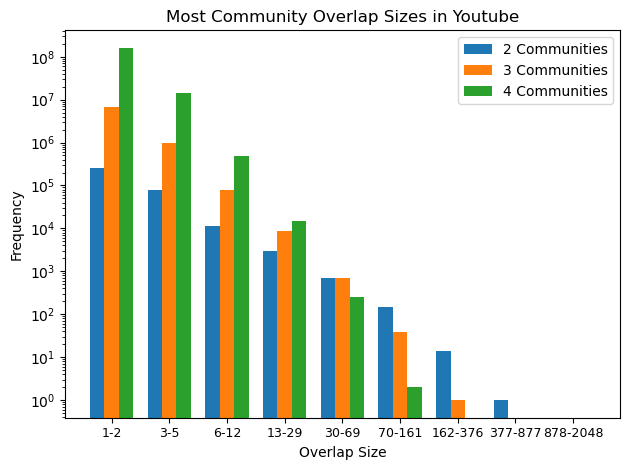

In [39]:
bins = np.logspace(0, 11, num=10, base=2, dtype="int64")
#bins = np.linspace(0, 700, num=10)
print(f"Bins: {bins}")

two_counts = np.histogram(list(two_overlaps.values()), bins=bins)[0]
three_counts = np.histogram(list(three_overlaps.values()), bins=bins)[0]
four_counts = np.histogram(list(four_overlaps.values()), bins=bins)[0]

bin_counts = {
    "2 Communities": two_counts,
    "3 Communities": three_counts,
    "4 Communities": four_counts
}
print(bin_counts)

x = np.arange(len(bins)-1)  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

bin_labels = [str(bins[i]+1)+"-"+str(bins[i+1]) for i in range(len(bins)-1)]
bin_labels[0] = "1-2"
bin_labels

fig, ax = plt.subplots()
#plt.grid()

for n_comms, count in bin_counts.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, count, width, label=n_comms)
    #ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Frequency')
ax.set_xlabel("Overlap Size")
ax.set_title('Most Community Overlap Sizes in LiveJournal')
ax.set_yscale('log')
ax.set_xticks(x + width, bin_labels, fontsize=9)
ax.legend()
#ax.set_ylim(0, 250)

plt.tight_layout()
plt.savefig("lj-overlaps.png")
plt.show()


In [28]:
## Estimate Powerlaw of each 
import powerlaw

## estimates for l' (xmin) and the exponent
print("Two Overlaps:")
vals = list(two_overlaps.values())
X = powerlaw.Fit(vals, discrete=True)
print("\nExponent:", X.power_law.alpha)
print("l':", X.power_law.xmin)
print("KS statistic:", X.power_law.D)
R, p = X.distribution_compare('power_law', 'exponential', normalized_ratio=True)
print("Compared to Exponential", R, p)
R, p = X.distribution_compare('power_law', 'truncated_power_law', normalized_ratio=True)
print("Compared to Truncated", R, p)
print("\n\n")

print("Three Overlaps:")
vals = list(three_overlaps.values())
X = powerlaw.Fit(vals, discrete=True)
print("\nExponent:", X.power_law.alpha)
print("l':", X.power_law.xmin)
print("KS statistic:", X.power_law.D)
R, p = X.distribution_compare('power_law', 'exponential', normalized_ratio=True)
print("Compared to Exponential", R, p)
R, p = X.distribution_compare('power_law', 'truncated_power_law', normalized_ratio=True)
print("Compared to Truncated", R, p)
print("\n\n")

print("Four Overlaps:")
vals = list(four_overlaps.values())
X = powerlaw.Fit(vals, discrete=True)
print("\nExponent:", X.power_law.alpha)
print("l':", X.power_law.xmin)
print("KS statistic:", X.power_law.D)
R, p = X.distribution_compare('power_law', 'exponential', normalized_ratio=True)
print("Compared to Exponential", R, p)
R, p = X.distribution_compare('power_law', 'truncated_power_law', normalized_ratio=True)
print("Compared to Truncated", R, p)

Two Overlaps:
Calculating best minimal value for power law fit
xmin progress: 99%
Exponent: 2.147245663801876
l': 3.0
KS statistic: 0.015825968888011133
Compared to Exponential 84.7315584898796 0.0


Assuming nested distributions


Compared to Truncated -9.466764176358167 0.0



Three Overlaps:
Calculating best minimal value for power law fit
xmin progress: 99%
Exponent: 2.1123679292667106
l': 31.0
KS statistic: 0.009748620368483896
Compared to Exponential 75.320224899997 0.0


Assuming nested distributions


Compared to Truncated -19.389985990654505 0.0



Four Overlaps:
Calculating best minimal value for power law fit
xmin progress: 99%
Exponent: 2.242950851437889
l': 29.0
KS statistic: 0.009869341678912291
Compared to Exponential 154.33600201641747 0.0


Assuming nested distributions


Compared to Truncated -34.04116269677669 0.0


# Repeat with ABCDoo

In [13]:
path = '../../ABCDGraphGenerator.jl/utils/'
#path = 'example2/'
#path = '../Datasets/ABCDoo/'
def readGraph():
    ## read edges, build graph
    fn = path+'abcdoo_dblp_d10_edge.dat'
    Edges = pd.read_csv(fn, sep='\t', header=None)-1
    G = ig.Graph.DataFrame(Edges, directed=False)
    ## read communities
    fn = path+'abcdoo_dblp_d10_com.dat'
    L = []
    with open(fn, "r") as infile:
        for line in infile:
            x = line.split('\t')
            coms = [int(y)-1 for y in x[1].rstrip()[1:-1].split(',')]  # map to 0-based
            try:
                coms.remove(0)  # Community 0 is outliers
            except ValueError:
                pass
            L.append(coms) 
    G.vs['comms'] = L
    G.vs['n_comms'] = [len(x) for x in G.vs['comms']]
    return G

g = readGraph()
print(f"{g.vcount()} vertices")
print(f"{g.ecount()} edges")

317080 vertices
2270594 edges


Min size: 11
Max size: 2738
Mean: 146.02047435637544


Text(0, 0.5, 'Frequency')

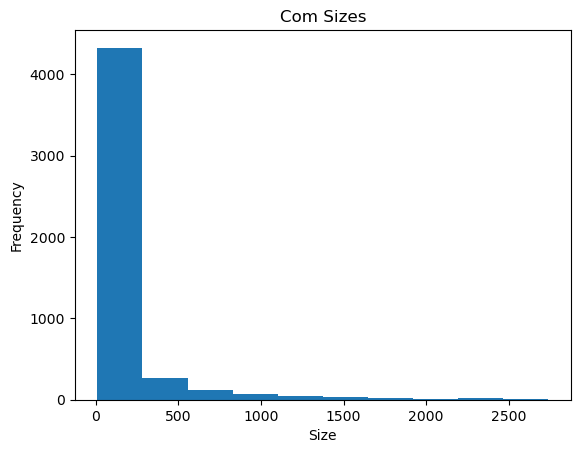

In [15]:
coms = defaultdict(set)
for i, com in enumerate(g.vs["comms"]):
    for c in com:
        coms[c].add(i)
coms = list(coms.values())

com_sizes = np.array([len(com) for com in coms])[:-1]

print(f"Min size: {np.min(com_sizes)}")
print(f"Max size: {np.max(com_sizes)}")
print(f"Mean: {np.mean(com_sizes)}")

plt.hist(com_sizes)
#plt.xscale("log")
#plt.yscale("log")
plt.title("Com Sizes")
plt.xlabel("Size")
plt.ylabel("Frequency")

Mean: 2.2717610697615744
Mean for non-zero: 2.759906206177825
Median: 2.0
Median for non-zero: 2.0
Max: 24
# no coms: 56082
% no coms: 0.17687019048820488


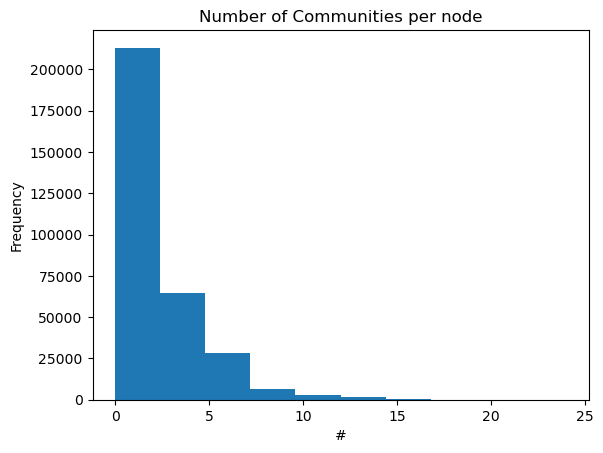

In [16]:
lens = np.array([len(i) for i in g.vs["comms"]])
plt.hist(lens)
plt.title("Number of Communities per node")
plt.xlabel("#")
plt.ylabel("Frequency")

print(f"Mean: {np.mean(lens)}")
print(f"Mean for non-zero: {np.mean(np.array(lens)[np.array(lens)>0])}")
print(f"Median: {np.median(lens)}")
print(f"Median for non-zero: {np.median(np.array(lens)[np.array(lens)>0])}")
print(f"Max: {np.max(lens)}")
print(f"# no coms: {np.sum(np.array(lens) == 0)}")
print(f"% no coms: {np.sum(np.array(lens) == 0) / len(lens)}")

In [17]:
print("Graph measurements of the ABCDoo graph.")

print(f"n = {g.vcount()}")
print(f"nout = {np.sum(lens == 0)}")
eta = np.mean(lens[lens>0])
print(f"eta = {eta: .2f}")

degrees = np.array(g.degree())
print(f"d_min = {np.min(degrees)}")
print(f"d_max = {np.max(degrees)}")
print(f"t1 = {powerlaw.Fit(degrees, discrete=True, verbose=False).power_law.alpha: .2f}         ") # Spaces are required to prevent some buffer overflow from printing a progress notice

com_sizes = np.array([len(com) for com in coms])

scaled_com_sizes = com_sizes/eta
large_com_sizes = scaled_com_sizes[scaled_com_sizes > 10] # Remove very small communities

print(f"c_min = {int(np.min(scaled_com_sizes))}")
print(f"c_max = {int(np.max(scaled_com_sizes))}")

print(f"t2 = {powerlaw.Fit(large_com_sizes, discrete=True, verbose=False, xmin=np.min(large_com_sizes)).power_law.alpha: .2f}         ") # Spaces are required to prevent some buffer overflow from printing a progress notice

Graph measurements of the ABCDoo graph.
n = 317080
nout = 56082
eta =  2.76
d_min = 5
d_max = 343
t1 =  2.31         
c_min = 3
c_max = 992
t2 =  1.68         


In [18]:
two_overlaps = defaultdict(int)
three_overlaps = defaultdict(int)
four_overlaps = defaultdict(int)

skipped = 0
for com in tqdm(g.vs["comms"]):
    if len(com) > 150:
        print(f"Skipping node with {len(com)} communities")
        skipped += 1
        continue

    for k2 in combinations(com, 2):
        two_overlaps[frozenset(k2)] += 1
    for k3 in combinations(com, 3):
        three_overlaps[frozenset(k3)] += 1
    for k4 in combinations(com, 4):
        four_overlaps[frozenset(k4)] += 1

print(f"Found {len(two_overlaps)} pairs of communities that overlap.")
print(f"Found {len(three_overlaps)} triples of communities that overlap.")
print(f"Found {len(four_overlaps)} quadruples of communities that overlap.")

print(f"Skipped {skipped} nodes.")

100%|██████████| 317080/317080 [00:09<00:00, 33192.52it/s]

Found 196865 pairs of communities that overlap.
Found 1177011 triples of communities that overlap.
Found 3242613 quadruples of communities that overlap.
Skipped 0 nodes.


Bins: [   1    2    5   12   29   69  161  376  877 2048]
{'2 Communities': array([78910, 62386, 31807, 15417,  6165,  1883,   295,     2,     0]), '3 Communities': array([795904, 301836,  65903,  12140,   1201,     27,      0,      0,
            0]), '4 Communities': array([2800625,  415994,   25090,     898,       6,       0,       0,
             0,       0])}


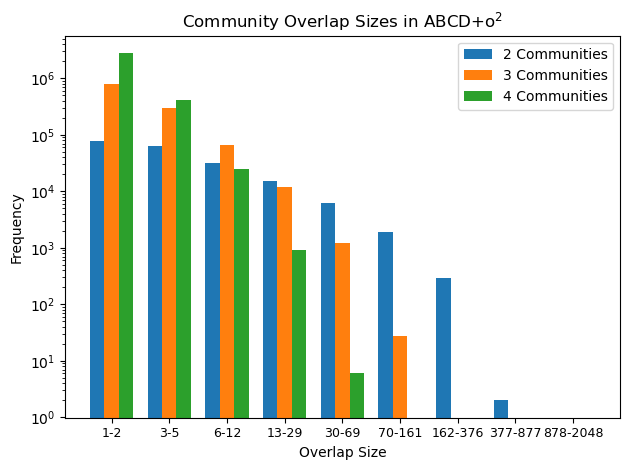

In [19]:
bins = np.logspace(0, 11, num=10, base=2, dtype="int64")
#bins = np.linspace(0, 700, num=10)
print(f"Bins: {bins}")

two_counts = np.histogram(list(two_overlaps.values()), bins=bins)[0]
three_counts = np.histogram(list(three_overlaps.values()), bins=bins)[0]
four_counts = np.histogram(list(four_overlaps.values()), bins=bins)[0]

bin_counts = {
    "2 Communities": two_counts,
    "3 Communities": three_counts,
    "4 Communities": four_counts
}
print(bin_counts)

x = np.arange(len(bins)-1)  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

bin_labels = [str(bins[i]+1)+"-"+str(bins[i+1]) for i in range(len(bins)-1)]
bin_labels[0] = "1-2"
bin_labels

fig, ax = plt.subplots()
#plt.grid()

for n_comms, count in bin_counts.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, count, width, label=n_comms)
    #ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Frequency')
ax.set_xlabel("Overlap Size")
ax.set_title('Community Overlap Sizes in ABCD+o'+r'$^2$')
ax.set_yscale('log')
ax.set_xticks(x + width, bin_labels, fontsize=9)
ax.legend()
#ax.set_ylim(0, 250)

plt.tight_layout()
#plt.savefig("abcdoo-dblp-d2-overlaps.png")
plt.show()

In [32]:
## Estimate Powerlaw of each 
import powerlaw

## estimates for l' (xmin) and the exponent
print("Two Overlaps:")
vals = list(two_overlaps.values())
X = powerlaw.Fit(vals, discrete=True, xmin=3)
print("\nExponent:", X.power_law.alpha)
print("l':", X.power_law.xmin)
print("KS statistic:", X.power_law.D)
R, p = X.distribution_compare('power_law', 'exponential', normalized_ratio=True)
print("Compared to Exponential", R, p)
R, p = X.distribution_compare('power_law', 'truncated_power_law', normalized_ratio=True)
print("Compared to Truncated", R, p)
print("\n\n")

print("Three Overlaps:")
vals = list(three_overlaps.values())
X = powerlaw.Fit(vals, discrete=True)
print("\nExponent:", X.power_law.alpha)
print("l':", X.power_law.xmin)
print("KS statistic:", X.power_law.D)
R, p = X.distribution_compare('power_law', 'exponential', normalized_ratio=True)
print("Compared to Exponential", R, p)
R, p = X.distribution_compare('power_law', 'truncated_power_law', normalized_ratio=True)
print("Compared to Truncated", R, p)
print("\n\n")

print("Four Overlaps:")
vals = list(four_overlaps.values())
X = powerlaw.Fit(vals, discrete=True)
print("\nExponent:", X.power_law.alpha)
print("l':", X.power_law.xmin)
print("KS statistic:", X.power_law.D)
R, p = X.distribution_compare('power_law', 'exponential', normalized_ratio=True)
print("Compared to Exponential", R, p)
R, p = X.distribution_compare('power_law', 'truncated_power_law', normalized_ratio=True)
print("Compared to Truncated", R, p)

Two Overlaps:

Exponent: 1.9137831613566412
l': 3.0
KS statistic: 0.05013120930210391
Compared to Exponential 49.20207941632336 0.0


Assuming nested distributions


Compared to Truncated -47.5474446420264 0.0



Three Overlaps:
Calculating best minimal value for power law fit
xmin progress: 98%
Exponent: 2.6345319624115406
l': 3.0
KS statistic: 0.01995139072804053
Compared to Exponential 41.18489062146331 0.0


Assuming nested distributions


Compared to Truncated -43.15966595676048 0.0



Four Overlaps:
Calculating best minimal value for power law fit
xmin progress: 96%
Exponent: 4.216720016300227
l': 5.0
KS statistic: 0.013707472261861975
Compared to Exponential 6.124944677448804 9.071512037797929e-10


Assuming nested distributions


Compared to Truncated -10.132002680149482 0.0
